In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def ecdf(data):
    x = np.sort(data)
    n = len(data)
    y = np.arange(1, len(x)+1)/n
    return x,y

In [3]:
sellers_data = pd.read_csv('../input/olist_sellers_dataset.csv')
product_cat = pd.read_csv('../input/product_category_name_translation.csv')
orders_dataset = pd.read_csv('../input/olist_orders_dataset.csv')
order_items_dataset = pd.read_csv('../input/olist_order_items_dataset.csv')
customers_dataset = pd.read_csv('../input/olist_customers_dataset.csv')
geolocation_dataset = pd.read_csv('../input/olist_geolocation_dataset.csv')
order_payments_dataset = pd.read_csv('../input/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv('../input/olist_order_reviews_dataset.csv')
products_dataset = pd.read_csv('../input/olist_products_dataset.csv')




## Improve ETD accuracy

Improving ETD can be interpreted as:
    1. what is the states that has the lowest time delivery
    2. How does current ETD estimator reflects the true behaviour 

In [67]:
df_all = pd.merge(orders_dataset, customers_dataset, on='customer_id')
df_all = pd.merge(order_items_dataset, df_all, on='order_id')

In [68]:
df_all['order_purchase_timestamp'] = pd.to_datetime(df_all.order_purchase_timestamp)

In [71]:
clean_data = df_all.dropna()

clean_data['shipping_limit_date'] = pd.to_datetime(clean_data.shipping_limit_date)
clean_data['order_approved_at'] = pd.to_datetime(clean_data.order_approved_at)
clean_data['order_delivered_carrier_date'] = pd.to_datetime(clean_data.order_delivered_carrier_date)
clean_data['order_delivered_customer_date'] = pd.to_datetime(clean_data.order_delivered_customer_date)
clean_data['order_estimated_delivery_date'] = pd.to_datetime(clean_data.order_estimated_delivery_date)




convert to date time

In [73]:
clean_data['delta_ord_arrive_time'] = (clean_data.order_delivered_customer_date - clean_data.order_approved_at).dt.days
clean_data['delta_est_ord_arrive_time'] = (clean_data.order_estimated_delivery_date - clean_data.order_approved_at).dt.days
clean_data['delta_true_time_est_time'] = (clean_data.order_delivered_carrier_date - clean_data.order_estimated_delivery_date).dt.days


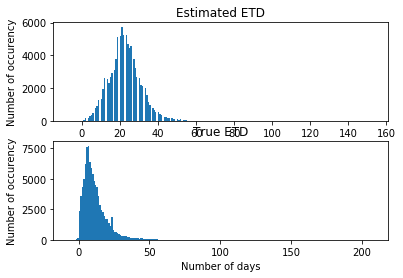

In [8]:
ETD_orders = clean_data.delta_est_ord_arrive_time.tolist()
True_EDT_orders = clean_data.delta_ord_arrive_time.tolist()

plt.subplot(2,1,1)
plt.title('Estimated ETD')
plt.xlabel('Number of days')
plt.ylabel('Number of occurency')
plt.hist(ETD_orders, bins=max(True_EDT_orders))

plt.subplot(2,1,2)
plt.title('True ETD')
plt.xlabel('Number of days')
plt.ylabel('Number of occurency')
plt.hist(True_EDT_orders, bins=max(True_EDT_orders))



plt.show()

It is kindly hard to say anything about this this, let's plot the ECDF for more details
1. how close they are
2. how much does it deviate



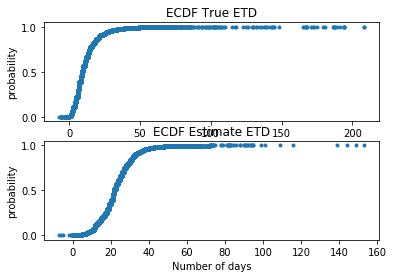

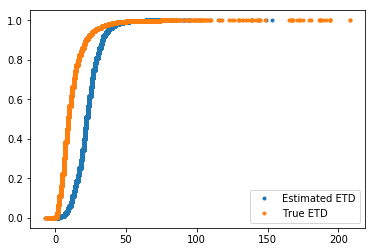

In [9]:
x_est_ETD, y_est_ETD = ecdf(ETD_orders)
x_ETD, y_ETD = ecdf(True_EDT_orders)


plt.plot()

plt.subplot(2,1,1)
plt.title('ECDF True ETD')
plt.xlabel('Number of days')
plt.ylabel('probability')
plt.plot(x_ETD,y_ETD, marker='.', linestyle='none')

plt.subplot(2,1,2)
plt.title('ECDF Estimate ETD')
plt.xlabel('Number of days')
plt.ylabel('probability')
plt.plot(x_est_ETD, y_est_ETD, marker='.', linestyle='none')

plt.show()


plt.plot(x_est_ETD, y_est_ETD, marker='.', linestyle='none')
plt.plot(x_ETD,y_ETD, marker='.', linestyle='none')

plt.legend(['Estimated ETD','True ETD'])
plt.show()




It looks like it is getting the right prediction only when the EST are greater than 40 days with probability of .89. 
But if we look deeper the model, this holds only for a limited number of states, not at all of them 

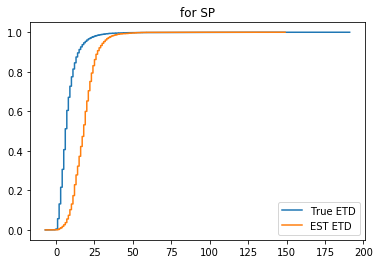

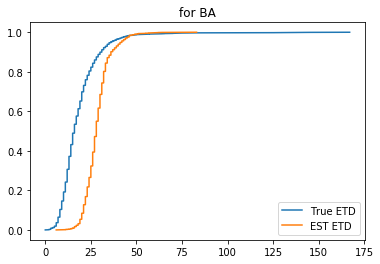

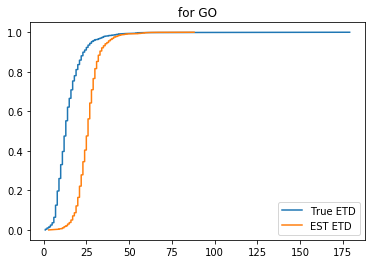

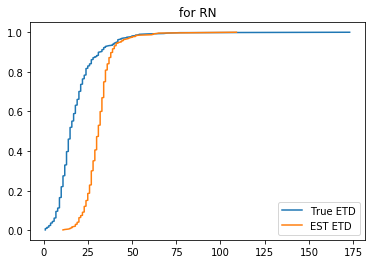

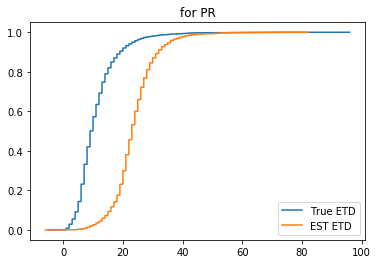

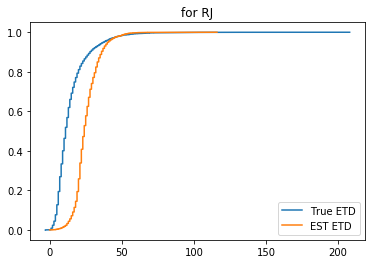

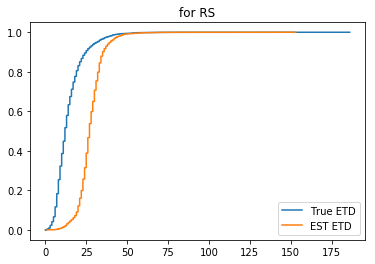

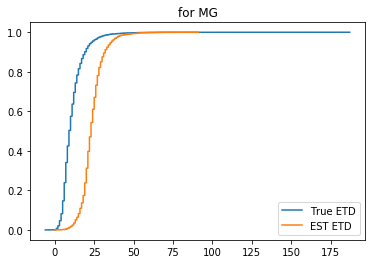

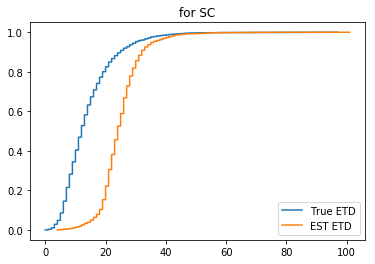

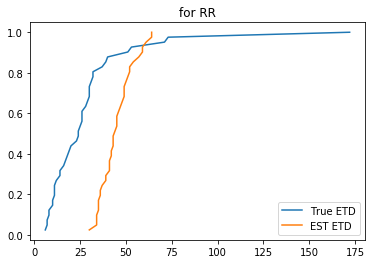

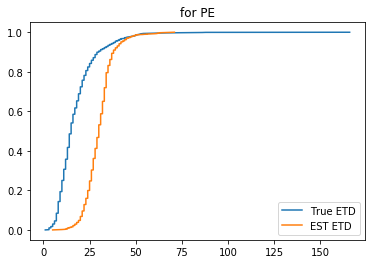

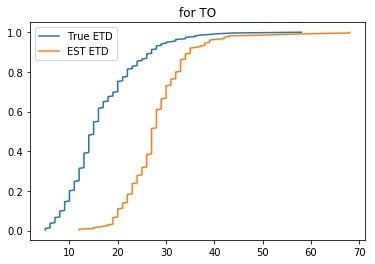

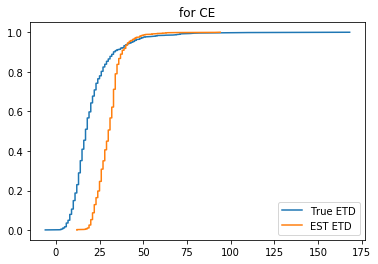

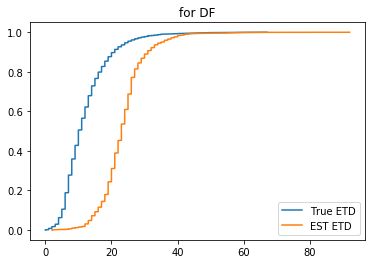

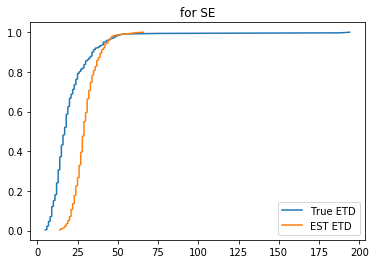

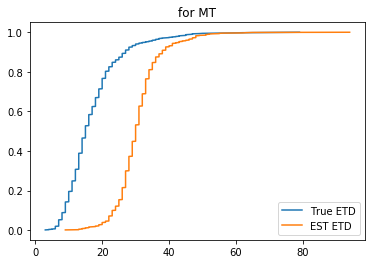

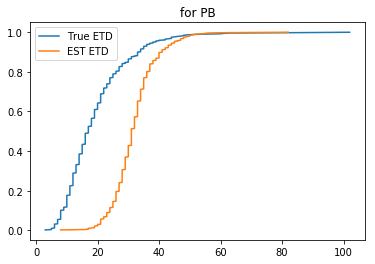

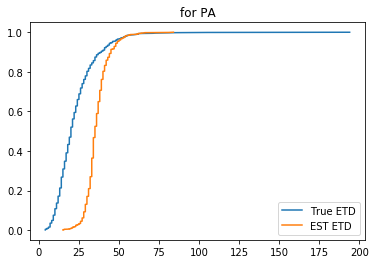

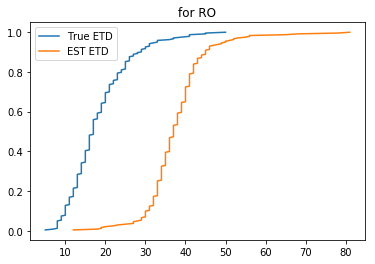

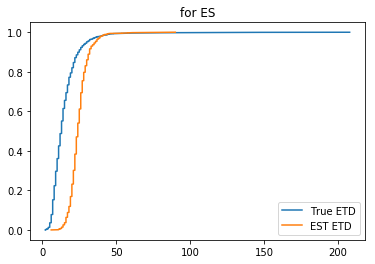

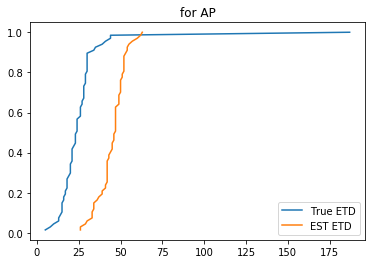

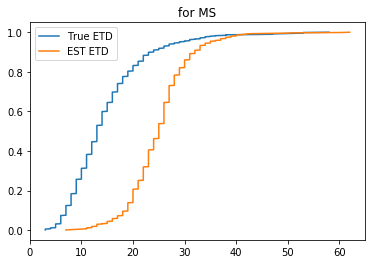

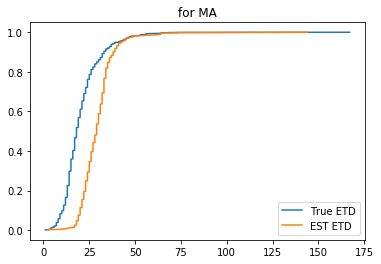

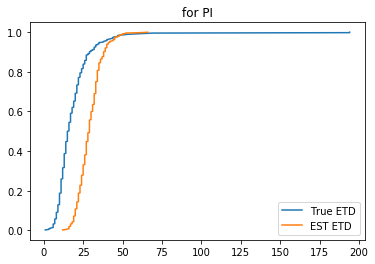

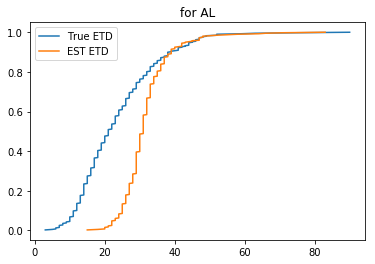

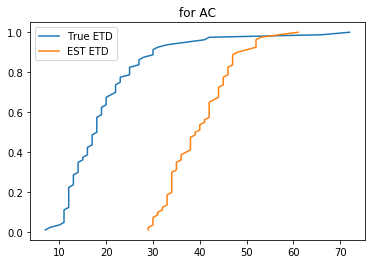

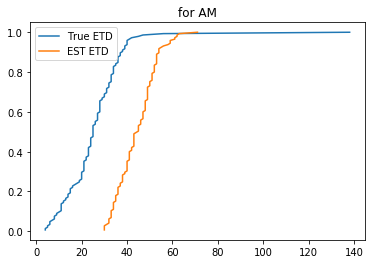

In [69]:
# states = clean_data.customer_state.unique().tolist()
# figures = []

# def plot_ecdf(df):
#     ETD_orders = df.delta_est_ord_arrive_time.tolist()
#     True_EDT_orders = df.delta_ord_arrive_time.tolist()
    
#     x_est_ETD, y_est_ETD = ecdf(ETD_orders)
#     x_ETD, y_ETD = ecdf(True_EDT_orders)
#     _ = plt.plot(x_ETD, y_ETD)
#     _ = plt.plot(x_est_ETD, y_est_ETD)
#     _ = plt.title('for {}'.format(df.customer_state.tolist()[-1]))
#     _ = plt.legend(['True ETD', 'EST ETD'])
    
#     _ = plt.show()
    
    

# for s in states:
#     plot_ecdf(clean_data[clean_data.customer_state == s])




Since we are trying to make prediction about the true ETD, we have to drop the their model data column

In [ ]:
import sklearn

In [76]:
clean_data.columns.tolist()

['order_id',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'delta_ord_arrive_time',
 'delta_est_ord_arrive_time',
 'delta_true_time_est_time']

I stick with the following features: ['shipping_limit_date', 'price', 'freight_value', 'customer_zip_code_prefix','customer_state']

At first: if an item hasn't been shipped till the limit dates there is no point to wait for that item at all, 
second the price and shipping price of an item have influence on shipping cost and client budget

In [107]:
zip_codes = clean_data.customer_zip_code_prefix.unique().tolist()
custome_state = clean_data.customer_state.unique().tolist()

clean_data['customer_zip_code_prefix'] = pd.Categorical(clean_data['customer_zip_code_prefix'], categories = zip_codes, ordered=False)
clean_data['customer_state'] = pd.Categorical(clean_data['customer_state'], categories=custome_state, ordered=False)



In [ ]:
clean_data['shipping_limit_date'] = clean_data.shipping_limit_date.dt.day
clean_data[['shipping_limit_date', 'price', 'freight_value', 'customer_zip_code_prefix','customer_state', 'delta_ord_arrive_time']]

In [155]:
# train_data = clean_data[['shipping_limit_date', 'price', 'freight_value', 'customer_zip_code_prefix','customer_state', 'delta_ord_arrive_time']].copy()
train_data = clean_data[['shipping_limit_date', 'price', 'freight_value', 'customer_zip_code_prefix','customer_state', 'delta_ord_arrive_time', 'delta_est_ord_arrive_time']].copy()

selected_columns = X_train.columns.difference(\
                                              ['customer_zip_code_prefix','customer_state', 'delta_est_ord_arrive_time','delta_ord_arrive_time'])

y = train_data['delta_ord_arrive_time']
# train_data.drop(columns=['delta_ord_arrive_time'], inplace=True)

In [156]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.3)

lm = LinearRegression(n_jobs=-1)
lm.fit(X_train[selected_columns], y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [157]:
ynew = lm.predict(X_test[selected_columns])

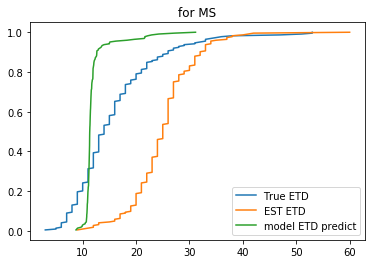

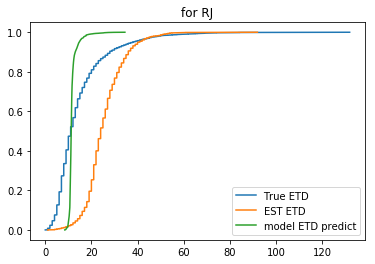

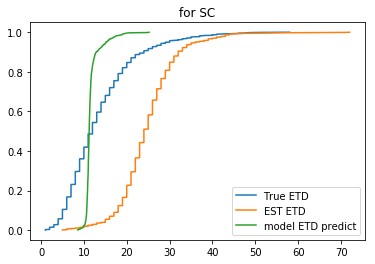

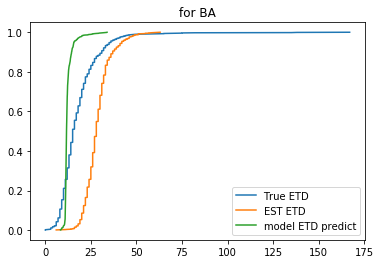

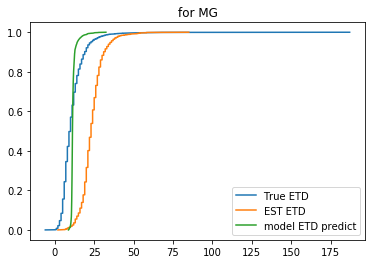

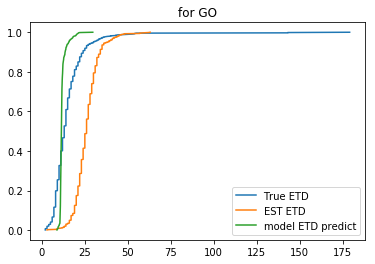

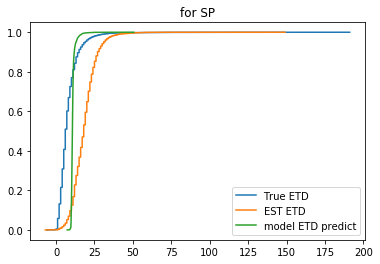

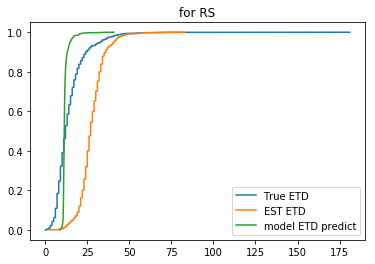

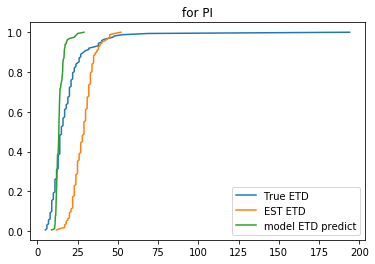

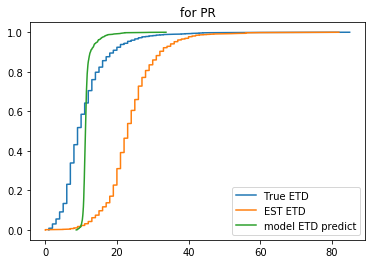

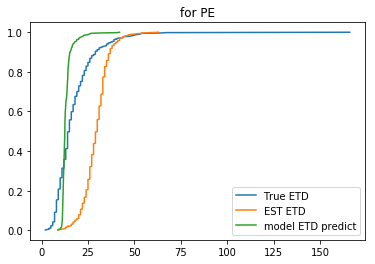

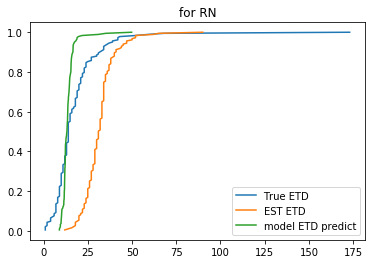

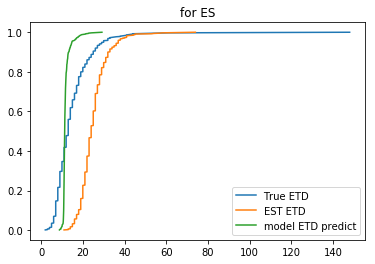

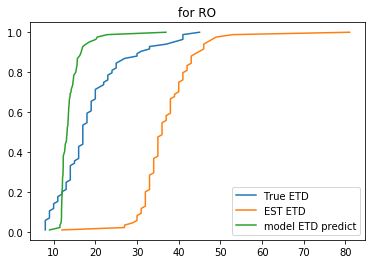

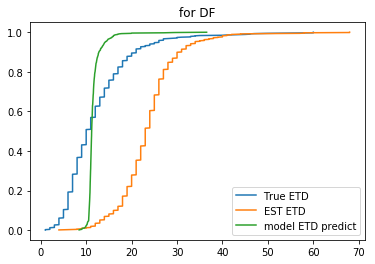

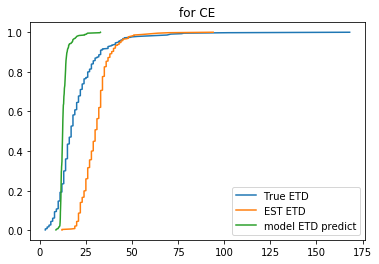

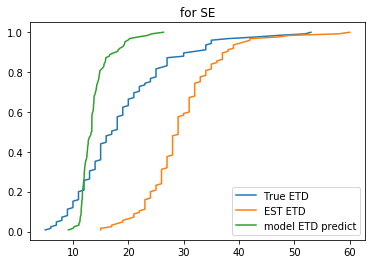

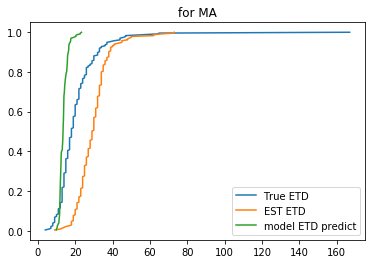

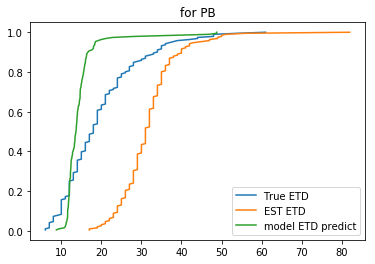

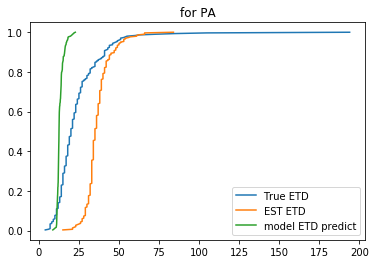

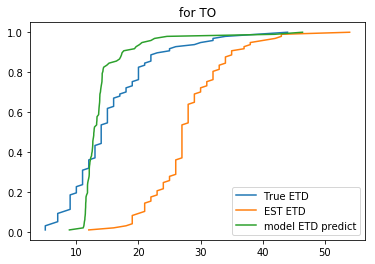

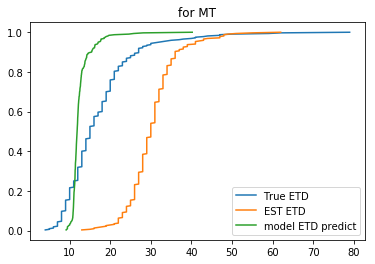

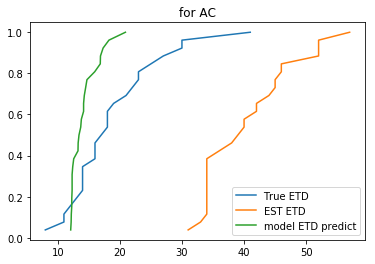

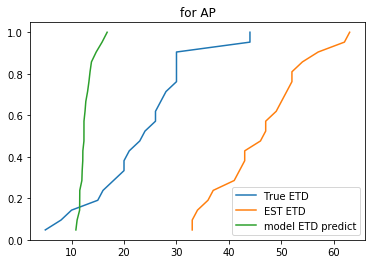

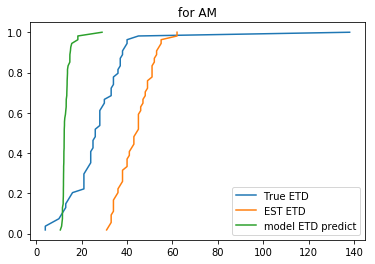

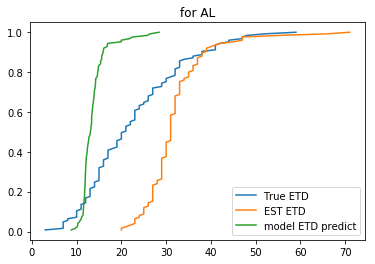

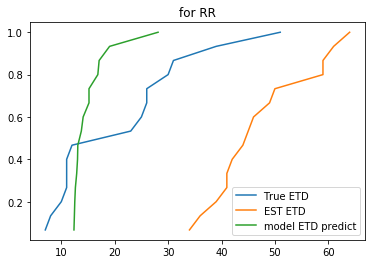

In [158]:
# for i in range(len(X_test)):
#     print("X=%s, Predicted=%s, existing model = %s" % (ynew[i], y_test.tolist()[i], clean_data['delta_est_ord_arrive_time'].tolist()[i]))
X_test['our_model_predict'] = ynew

states = X_test.customer_state.unique().tolist()
figures = []

def plot_ecdf(df):
    ETD_orders = df.delta_est_ord_arrive_time.tolist()
    True_EDT_orders = df.delta_ord_arrive_time.tolist()
    model_ETD_orders = df.our_model_predict.tolist()
    
    x_est_ETD, y_est_ETD = ecdf(ETD_orders)
    x_ETD, y_ETD = ecdf(True_EDT_orders)
    x_model_ETD, y_model_ETD = ecdf(model_ETD_orders)
    
    _ = plt.plot(x_ETD, y_ETD)
    _ = plt.plot(x_est_ETD, y_est_ETD)
    _ = plt.plot(x_model_ETD, y_model_ETD)
    _ = plt.title('for {}'.format(df.customer_state.tolist()[-1]))
    _ = plt.legend(['True ETD', 'EST ETD', 'model ETD predict'])
    
    _ = plt.show()
    
    

for s in states:
    plot_ecdf(X_test[clean_data.customer_state == s])





let's plot the ECDF and see how closely to the truth shape they are

##  Pick better fulfillment plans, better meaning "faster" or "cheaper"


In [ ]:
# code goes below
# find the min of time which takes to an item to arrive

## Improve conversion and maximize revenue by dynamically pricing premium delivery options for loyal customers

In [ ]:
# code goes below